In [23]:
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import math
from math import hypot
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier

# NFL 2021 Big Data Bowl

## Get Data

In [31]:
plays = pd.read_csv(r"/Users/ishanidesai/Documents/sports_analytics/nfl-big-data-bowl-2021/plays.csv")
week1 = pd.read_csv(r"/Users/ishanidesai/Documents/sports_analytics/nfl-big-data-bowl-2021/week1.csv")

# JOINING WEEK 1 TRACKING DATA AND PLAY DATA
week1_tracking = plays.merge(week1, how = 'inner', on=['gameId', 'playId'], sort=False)

cols = ['gameId', 'playId', 'quarter', 'down', 'yardsToGo', 'playType', 'defendersInTheBox', 'numberOfPassRushers', 'personnelD', 'isDefensivePI', 'passResult', 'time', 'x', 'y', 's', 'a', 'dis', 'event', 'nflId', 'displayName', 'jerseyNumber', 'position', 'frameId', 'team', 'playDirection', 'route']
week1_tracking = week1_tracking[cols]


## Combining Tracking Data w/ Week 1 Data

In [32]:
week1_tracking = week1_tracking.loc[week1_tracking['playType'] == 'play_type_pass']

week1_games = week1['gameId'].unique()
print(week1_games)
week1_plays = plays[plays.gameId.isin(week1_games)]
week1_plays['off_dist'] = -1
week1_plays['def_dist'] = -1
week1_plays['defender_receiver_dist'] = -1
week1_plays['closest_defender'] = ''
# only want plays where pass result is interception or incomplete, and only the frames where the action int/incomplete happens
week1_plays = week1_plays[week1_plays.passResult.isin(['IN', 'I', 'C'])]

week1_tracking = week1_tracking[week1_tracking.event.isin(['pass_outcome_incomplete', 'pass_outcome_interception', 'pass_outcome_caught'])]

print(week1_tracking.shape)
week1_tracking.head()


[2018090600 2018090906 2018090907 2018090903 2018090901 2018090902
 2018090900 2018090905 2018090909 2018090910 2018090912 2018091000
 2018091001]
(13354, 26)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

,gameId,playId,quarter,down,yardsToGo,playType,defendersInTheBox,numberOfPassRushers,personnelD,isDefensivePI,passResult,time,x,y,s,a,dis,event,nflId,displayName,jerseyNumber,position,frameId,team,playDirection,route
714,2018090600,75,1,1,15,play_type_pass,7.0,4.0,"4 DL, 2 LB, 5 DB",False,C,2018-09-07T01:07:19.700Z,96.10,27.82,0.99,1.14,0.10,pass_outcome_caught,310.0,Matt Ryan,2.0,QB,52,away,left,NaN
715,2018090600,75,1,1,15,play_type_pass,7.0,4.0,"4 DL, 2 LB, 5 DB",False,C,2018-09-07T01:07:19.700Z,81.74,49.08,7.94,2.37,0.80,pass_outcome_caught,79848.0,Malcolm Jenkins,27.0,SS,52,home,left,NaN
716,2018090600,75,1,1,15,play_type_pass,7.0,4.0,"4 DL, 2 LB, 5 DB",False,C,2018-09-07T01:07:19.700Z,81.48,50.13,4.93,3.07,0.49,pass_outcome_caught,2495454.0,Julio Jones,11.0,WR,52,away,left,HITCH
717,2018090600,75,1,1,15,play_type_pass,7.0,4.0,"4 DL, 2 LB, 5 DB",False,C,2018-09-07T01:07:19.700Z,81.41,19.08,4.65,2.84,0.46,pass_outcome_caught,2495613.0,Corey Graham,24.0,FS,52,home,left,NaN
718,2018090600,75,1,1,15,play_type_pass,7.0,4.0,"4 DL, 2 LB, 5 DB",False,C,2018-09-07T01:07:19.700Z,76.75,36.60,2.82,1.85,0.28,pass_outcome_caught,2533040.0,Mohamed Sanu,12.0,WR,52,away,left,HITCH


## Calculate Distances between receiver/defenders, and from the ball

In [46]:
dists = pd.DataFrame(columns=['playId', 'distance'])
# for every play (playid), get the football x and y. find the distance between the football xy
# get closest for home and closest for away. get distance between those 2and each player's xy

print(week1_tracking.event.unique())

for gameId in week1_tracking.gameId.unique():
    game_specific = week1_tracking.loc[week1_tracking['gameId'] == gameId]
    
    for playId in game_specific.playId.unique():
        # get the tracking data for players/ball in specific play
        play_specific = game_specific.loc[game_specific['playId'] == playId]
        
        # get x, y coords of football
        football = play_specific.loc[play_specific['displayName'] == 'Football']
        football_x = football['x'].iloc[0]
        football_y = football['y'].iloc[0]
        
        players = play_specific.loc[play_specific['displayName'] != 'Football']
        
        # figure out whether home or away team is on offense based on QB
        offense = (play_specific.loc[play_specific['position'] == 'QB'])['team'].iloc[0]
        
        first_off = 1 # flags for initial offense and defense values 
        first_def = 1
        off_dist = 0  # distance from the ball of closest receiver and defender
        def_dist = 0
        off_closest = 0 # rows w/ player info of closest receiver and defender
        def_closest = 0
        
        # for every player in the play, calculate their distance from the football check if its the closest
        for index, row in players.iterrows():
            player_x = row['x']
            player_y = row['y']
            dist = math.hypot(football_x - player_x, football_y - player_y)
            if ((first_off == 1) or (first_def == 1)):
                if ((first_off == 1) or (row['team'] == offense)):
                    first_off = 0
                    off_closest = row
                    off_dist = dist
                else:
                    first_def = 0
                    def_closest = row
                    def_dist = dist
                continue

            if ((row['team'] == offense) and (dist < off_dist)):
                off_closest = row
                off_dist = dist
            elif ((row['team'] != offense) and (dist < def_dist)):
                def_closest = row
                def_dist = dist

        week1_plays.loc[(week1_plays.playId == playId) & (week1_plays.gameId == gameId), 'off_dist'] = off_dist
        week1_plays.loc[(week1_plays.playId == playId) & (week1_plays.gameId == gameId), 'def_dist'] = def_dist
        dist = math.hypot(off_closest['x'] - def_closest['x'], off_closest['y'] - def_closest['y'])
        week1_plays.loc[(week1_plays.playId == playId) & (week1_plays.gameId == gameId), 'defender_receiver_dist'] = dist
        week1_plays.loc[(week1_plays.playId == playId) & (week1_plays.gameId == gameId), 'closest_defender'] = def_closest['displayName']
        #print(gameId, playId, off_dist)
week1_plays.head()
print(week1_plays.shape)

['pass_outcome_caught' 'pass_outcome_incomplete'
 'pass_outcome_interception']
(967, 31)


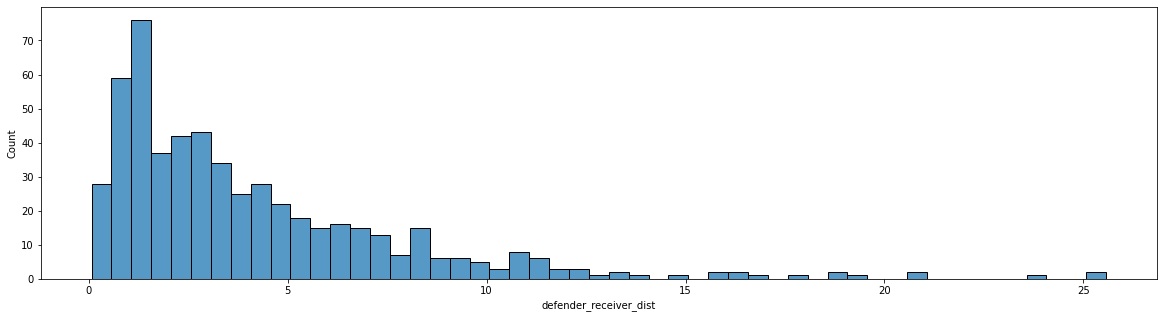

In [39]:
complete_passes = week1_plays.loc[(week1_plays.defender_receiver_dist >= 0) & (week1_plays.passResult == 'C'), 'defender_receiver_dist']
plt.figure(figsize=(20, 5))
sns.histplot(data=complete_passes, binwidth=0.5)
#ax = sns.boxplot(x=complete_passes)
#ax = sns.swarmplot(x=complete_passes, color=".25")


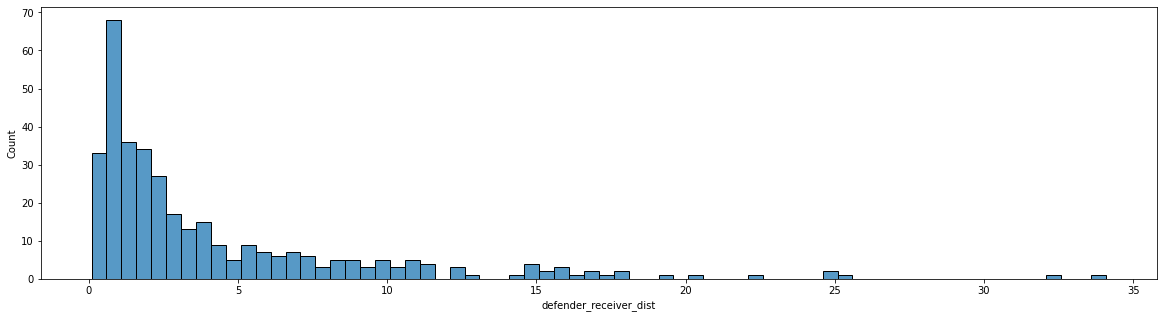

In [38]:
incomplete_passes = week1_plays.loc[(week1_plays.defender_receiver_dist >= 0) & (week1_plays.passResult != 'C'), 'defender_receiver_dist']
plt.figure(figsize=(20, 5))
sns.histplot(data=incomplete_passes, binwidth=0.5)
#ax = sns.heatmap(data=incomplete_passes.defender_receiver_dist)
#ax = sns.boxplot(x=incomplete_passes)
#ax = sns.swarmplot(x=incomplete_passes, color=".25")


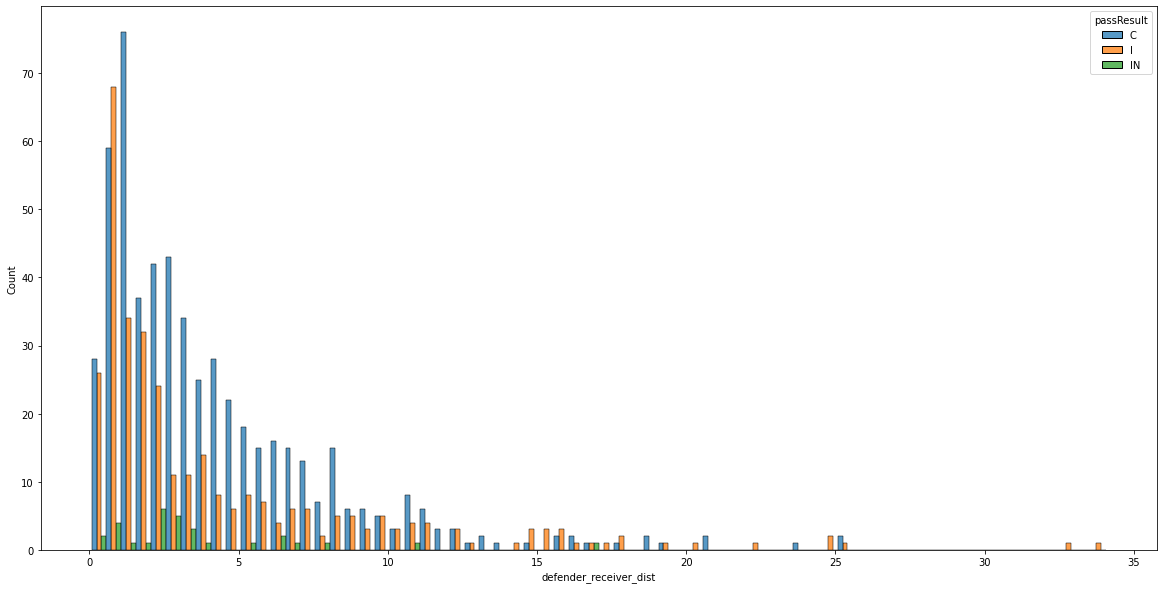

In [40]:
valid_passes = week1_plays.loc[(week1_plays.defender_receiver_dist >= 0)]
#valid_passes.head()
plt.figure(figsize=(20, 10))
sns.histplot(data=valid_passes, x='defender_receiver_dist', binwidth=0.5, hue='passResult', multiple='dodge')


In [44]:
defenders = valid_passes.closest_defender.unique()
defenders

array(['Malcolm Jenkins', 'Jordan Hicks', 'Sidney Jones', 'Ronald Darby',
       'Robert Alford', 'Ricardo Allen', 'Nate Gerry', 'Rodney McLeod',
       'Corey Graham', "De'Vondre Campbell", 'Brian Poole', 'Deion Jones',
       'Duke Riley', 'Vic Beasley', 'Desmond Trufant', 'Jalen Mills',
       'Keanu Neal', 'Rasul Douglas', 'Christian Kirksey', 'Joe Schobert',
       'Jon Bostic', 'Mike Hilton', 'Jamie Collins', 'Denzel Ward',
       'Vince Williams', 'Joe Haden', 'Briean Boddy-Calhoun',
       'Derrick Kindred', 'Damarious Randall', 'T.J. Watt',
       'Terrance Mitchell', 'Jabrill Peppers', 'Sean Davis',
       'Terrell Edmunds', 'Artie Burns', 'Bud Dupree', 'Cameron Sutton',
       'Kenny Moore', 'Preston Brown', 'Nate Hairston', 'Malik Hooker',
       'Clayton Geathers', 'Dre Kirkpatrick', 'Darqueze Dennard',
       'Jordan Evans', 'Clayton Fejedelem', 'Anthony Walker',
       'Quincy Wilson', 'William Jackson', 'Darius Leonard',
       'Jessie Bates', 'Nick Vigil', 'Hardy Nicke